# Interaction between nuisance models and Lya theory

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
from cup1d.nuisance import mean_flux_model
from cup1d.likelihood import lya_theory

In [2]:
# construct two models for the mean flux, with different number of parameters
mf_model_test=mean_flux_model.MeanFluxModel(ln_tau_coeff=[1,0,-0.1])
mf_model_fid=mean_flux_model.MeanFluxModel()

In [3]:
# create default Lya theory with default mean flux model
zs=[2.0,3.0,4.0]
free_param_names=['ln_tau_0','ln_tau_1','ln_tau_2']
theory=lya_theory.Theory(zs=zs,free_param_names=free_param_names)

using default values for emulator pivot point


In [7]:
# access mean flux parameters
params=theory.mf_model_fid.get_parameters()
Np=len(params)
# will create new param array and set values
like_params=[]
values=[0]*Np
values[0]=-0.05
values[-1]=0.15
print(values)
for ip in range(Np):
    par=params[ip].get_new_parameter(0.5)
    par.set_without_cube(values[ip])
    like_params.append(par)
    print(params[ip].info_str(all_info=True),par.info_str())

[-0.05, 0, 0.15]
ln_tau_0 = 0.0 , -0.1 , 0.1 ln_tau_0 = -0.05
ln_tau_1 = 0.0 , -0.2 , 0.2 ln_tau_1 = 0
ln_tau_2 = 0.0 , -0.2 , 0.2 ln_tau_2 = 0.15


In [8]:
igm_models=theory.get_igm_models(like_params)
mf_model=igm_models['mf_model']

Text(0.5, 1.0, 'Effective optical depth')

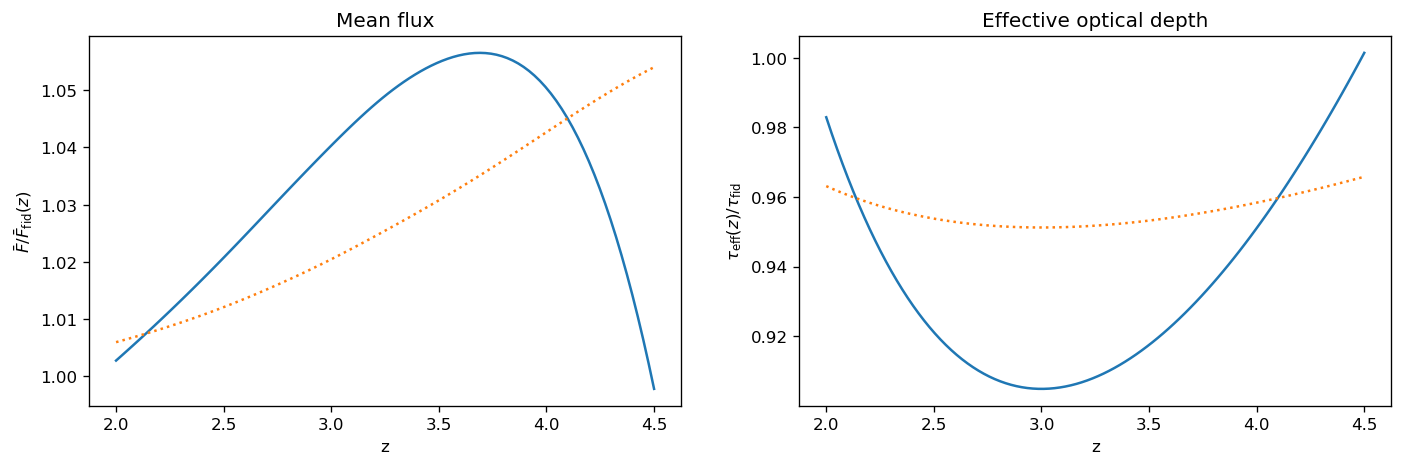

In [6]:
z=np.linspace(2.0,4.5,100)
plt.figure(figsize=[14,4])
# start with mean flux
plt.subplot(1, 2, 1)
plt.plot(z,mf_model_test.get_mean_flux(z)/mf_model_fid.get_mean_flux(z))
plt.plot(z,mf_model.get_mean_flux(z)/mf_model_fid.get_mean_flux(z),ls=':')
plt.xlabel('z')
plt.ylabel(r'$\bar{F} / \bar{F}_{\rm fid}(z)$')
plt.title('Mean flux')
# now effective optical depth
plt.subplot(1, 2, 2)
plt.plot(z,mf_model_test.get_tau_eff(z)/mf_model_fid.get_tau_eff(z))
plt.plot(z,mf_model.get_tau_eff(z)/mf_model_fid.get_tau_eff(z),ls=':')
plt.xlabel('z')
plt.ylabel(r'$\tau_{\rm eff}(z) / \tau_{\rm fid}$')
plt.title('Effective optical depth')